In [8]:
import pandas as pd
import datetime
import matplotlib.dates as mdates
import numpy as np
import glob
import os
from tqdm import tqdm

# Samsung-All

In [9]:
output_dir = '../Data/Samsung/samsung-security-updates'

# List to hold dataframes
dfs = []

# List all CSVs in the directory
csv_files = [f for f in os.listdir(output_dir) if f.endswith('.csv')]

# Iterate over each file with progress bar
for file in tqdm(csv_files, desc="Loading CSVs"):
    # Read the CSV and append to the list
    dfs.append(pd.read_csv(f"{output_dir}/{file}"))

# Concatenate all dataframes in the list
df_samsung = pd.concat(dfs, ignore_index=True)

Loading CSVs: 100%|█████████████████████████████| 40/40 [00:03<00:00, 10.29it/s]


## Feature Extraction

In [10]:
import pandas as pd
import datetime
import matplotlib.dates as mdates
import numpy as np


df_knox_models = pd.read_csv('../Data/Samsung/knox-models-all.csv')
df_csc = pd.read_csv('../Data/Samsung/CSC-list.csv')

df_samsung["security_patch_level"] = df_samsung["security_patch_level"].astype("datetime64")
df_samsung["release_date"] = df_samsung["release_date"].astype("datetime64")


d = []
counter = 0

for i in df_samsung['id'].unique():
    
    #get the model and CSC code from the unique pair id
    [model,CSC] = i.split('/')
    
    #extract carrier_country from CSC dataset
    cc= df_csc[df_csc['CSC']==CSC]['carrier/country'].to_list()
    carrier_country = cc[0]
    
    #extract carrier from CSC dataset
    car = df_csc[df_csc['CSC']==CSC]['carrier'].to_list()
    carrier = car[0]
    
    #extract country from CSC dataset
    cou = df_csc[df_csc['CSC']==CSC]['country'].to_list()
    country = cou[0]
    
    #extract ISO code from CSC dataset
    iso = df_csc[df_csc['CSC']==CSC]['iso_code'].to_list()
    iso_code = iso[0]
    
    #extract region from CSC dataset
    reg = df_csc[df_csc['CSC']==CSC]['region'].to_list()
    region = reg[0]
    
    #extract subregion from CSC dataset
    subreg = df_csc[df_csc['CSC']==CSC]['subregion'].to_list()
    subregion = subreg[0]

    #extract knox device from model
    k = df_knox_models.loc[df_knox_models['model']==model,'device'].to_list()
    if len(k) == 1:
        device = k[0]
    else:
        device = ''
        
    #extract device type knox devices
    dt = df_knox_models.loc[df_knox_models['model']==model,'device_type'].to_list()
    if len(dt) == 1:
        device_type= dt[0]
    else:
        device_type = ''

    #CALCULATE FEATURES
    #filter the dataset for the unique pair
    df_test = df_samsung[df_samsung['id']==i]
    
    #get the url
    url = 'https://doc.samsungmobile.com/' + i + '/doc.html'
    
    #extract all unique android version used for the unique pair
    android_versions = df_test['android_version'].unique()
    first_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[-1]
    last_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[0]

    #extract SPLs for the unique pair
    SPL_dates = df_test['security_patch_level']
    
    #calculate other fetures from SPL array for for the unique pair
    first_SPL = SPL_dates.min()
    last_SPL = SPL_dates.max()
    SPL_duration = SPL_dates.max()- SPL_dates.min()
    SPL_count = len(SPL_dates)
    SPL_freq = SPL_duration.days/SPL_count
    
    #extract Release dates for the unique pair
    release_dates = df_test['release_date']
    
    #calculate other fetures from ReleaseDates array for for the unique pair
    first_release_date = release_dates.min()
    last_release_date = release_dates.max()
    release_date_duration = release_dates.max() - release_dates.min()
    release_count = len(release_dates)
    avg_release_freq = release_date_duration.days/release_count
    
    #calculate avg delay in the release dates and SPL dates
    avg_release_delay = (df_test['release_date']-df_test['security_patch_level']).mean().days
    
    
    a = df_knox_models.loc[df_knox_models.model==model,'AER'].to_list()
    
    if len(a) >= 1:
        aer = a[0]
    else:
        aer = False
        
    p = df_knox_models.loc[df_knox_models.model==model,'platform'].to_list()
    
    if len(p) >= 1:
        platform = p[0]
    else:
        platform = 'No-Info'
        
    
    #create the final array
    d.append({'id': i,
             'device': device,
             'model': model,
             'CSC': CSC,
             'device_type': device_type,
             'aer': aer,
             'platform': platform,
             'carrier_country': carrier_country,
             'carrier': carrier,
             'country': country,
             'iso_code': iso_code,
             'region': region,
             'subregion': subregion,
             'android_versions': android_versions,
             'android_versions_str': ','.join(android_versions),
             'android_versions_count': len(android_versions),
             'first_OS': first_OS,
             'last_OS': last_OS,
             'first_SPL': first_SPL,
             'last_SPL': last_SPL,
             'SPL_duration': SPL_duration,
             'release_date_duration': release_date_duration,
             'SPL_count': SPL_count,
             'release_count': release_count,
             'SPL_freq': SPL_freq,
             'avg_release_freq': avg_release_freq,
             'first_release_date': first_release_date,
             'last_release_date': last_release_date,
             'avg_release_delay': avg_release_delay,
             'url': url})
    
    counter = counter + 1
    print('Completed {} / {}'.format(counter,len(df_samsung['id'].unique())), end='\r')

df_final_samsung = pd.DataFrame(d)

df_final_samsung.to_csv('../Data/Samsung/Samsung_security_updates_history_features.csv',index=False)

df_final_samsung.head()


,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
0,SM-A530F/ORO,Galaxy A8 (2018),SM-A530F,ORO,smartphone,False,Knox,Romania (Orange),Orange,Romania,...,1219 days,1330 days,34,34,35.852941,39.117647,2018-04-27,2021-12-17,38.0,https://doc.samsungmobile.com/SM-A530F/ORO/doc...
1,SM-A530F/ORS,Galaxy A8 (2018),SM-A530F,ORS,smartphone,False,Knox,Slovakia,No-carrier,Slovakia,...,1219 days,1330 days,34,34,35.852941,39.117647,2018-04-27,2021-12-17,39.0,https://doc.samsungmobile.com/SM-A530F/ORS/doc...
2,SM-A530F/ORX,Galaxy A8 (2018),SM-A530F,ORX,smartphone,False,Knox,Slovakia,No-carrier,Slovakia,...,1219 days,1420 days,40,40,30.475000,35.500000,2018-01-16,2021-12-06,29.0,https://doc.samsungmobile.com/SM-A530F/ORX/doc...
3,SM-A530F/PAK,Galaxy A8 (2018),SM-A530F,PAK,smartphone,False,Knox,Pakistan (PAK),PAK,Pakistan,...,1219 days,1457 days,36,36,33.861111,40.472222,2018-01-24,2022-01-20,30.0,https://doc.samsungmobile.com/SM-A530F/PAK/doc...
4,SM-A530F/PAN,Galaxy A8 (2018),SM-A530F,PAN,smartphone,False,Knox,Hungary (Telenor),Telenor,Hungary,...,1219 days,1309 days,22,22,55.409091,59.500000,2018-05-04,2021-12-03,36.0,https://doc.samsungmobile.com/SM-A530F/PAN/doc...


## Support lists

In [11]:
import warnings
warnings.filterwarnings("ignore")

df_timelines_samsung = pd.read_csv('../Data/Samsung/timelines_samsung_devices_v3.csv')
df_timelines_samsung[['monthly_start','monthly_end','quarterly_start','quarterly_end','biannually_start','biannually_end']] = df_timelines_samsung[['monthly_start','monthly_end','quarterly_start','quarterly_end','biannually_start','biannually_end']].apply(pd.to_datetime)
df_timelines_samsung[['monthly_duration','quarterly_duration','biannually_duration']] = df_timelines_samsung[['monthly_duration','quarterly_duration','biannually_duration']].apply(pd.to_timedelta)

df_eol = df_timelines_samsung[~df_timelines_samsung['biannually_duration'].isnull()].reset_index(drop=True)
biannual_ended_device_list = df_eol[df_eol['biannually_duration'].dt.days>0]['device'].unique()

df_final_biannual_ended = df_final_samsung[df_final_samsung['device'].isin(biannual_ended_device_list)]

df_final_biannual_ended['biannual_end'] = ''

for p in df_final_biannual_ended['device'].unique():
    biannual_end_date = df_timelines_samsung.loc[df_timelines_samsung['device']==p,'biannually_end'].item()
    
    df_final_biannual_ended.loc[df_final_biannual_ended['device']==p,'biannual_end'] = biannual_end_date
    
df_final_biannual_ended.head()

,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url,biannual_end
100,SM-A730F/ACR,Galaxy A8+ (2018),SM-A730F,ACR,smartphone,False,Knox,Saudi Arabia,No-carrier,Saudi Arabia,...,1388 days,16,16,66.625000,86.750000,2018-02-10,2021-11-29,67.0,https://doc.samsungmobile.com/SM-A730F/ACR/doc...,2022-02-08 00:01:56
101,SM-A730F/AFG,Galaxy A8+ (2018),SM-A730F,AFG,smartphone,False,Knox,Afghanistan,No-carrier,Afghanistan,...,1403 days,17,17,62.705882,82.529412,2018-01-26,2021-11-29,68.0,https://doc.samsungmobile.com/SM-A730F/AFG/doc...,2022-02-08 00:01:56
102,SM-A730F/AFR,Galaxy A8+ (2018),SM-A730F,AFR,smartphone,False,Knox,Kenya,No-carrier,Kenya,...,1306 days,16,16,66.625000,81.625000,2018-05-03,2021-11-29,72.0,https://doc.samsungmobile.com/SM-A730F/AFR/doc...,2022-02-08 00:01:56
103,SM-A730F/ALE,Galaxy A8+ (2018),SM-A730F,ALE,smartphone,False,Knox,Ecuador,No-carrier,Ecuador,...,1267 days,13,13,96.076923,97.461538,2018-08-17,2022-02-04,62.0,https://doc.samsungmobile.com/SM-A730F/ALE/doc...,2022-02-08 00:01:56
104,SM-A730F/BNG,Galaxy A8+ (2018),SM-A730F,BNG,smartphone,False,Knox,Bangladesh,No-carrier,Bangladesh,...,1353 days,15,15,69.000000,90.200000,2018-02-15,2021-10-30,73.0,https://doc.samsungmobile.com/SM-A730F/BNG/doc...,2022-02-08 00:01:56


## Read the security updates and add country, carrier, and device info

In [12]:
output_dir = '../Data/Samsung/samsung-security-updates'

# List to hold dataframes
dfs = []

# List all CSVs in the directory
csv_files = [f for f in os.listdir(output_dir) if f.endswith('.csv')]

# Iterate over each file with progress bar
for file in tqdm(csv_files, desc="Loading CSVs"):
    # Read the CSV and append to the list
    dfs.append(pd.read_csv(f"{output_dir}/{file}"))

# Concatenate all dataframes in the list
df_samsung = pd.concat(dfs, ignore_index=True)

Loading CSVs: 100%|█████████████████████████████| 40/40 [00:03<00:00, 10.39it/s]


In [13]:
import glob
import pandas as pd
from datetime import datetime
import os


df_knox_models = pd.read_csv('../Data/Samsung/knox-models-all.csv')
df_csc = pd.read_csv('../Data/Samsung/CSC-list.csv')

#create a unique pair code for pairs
df_samsung['id'] = df_samsung['model']+'/'+df_samsung['CSC']

counter=0

for i in df_samsung.index:

    m = df_samsung.loc[i,'model']

    k = df_knox_models.loc[df_knox_models['model']==m,'device'].to_list()

    if len(k) == 1:
        device = k[0]
    else:
        device = ''

    df_samsung.at[i,'device'] = device

    c= df_samsung.loc[i,'CSC']

    cc=df_csc.loc[df_csc['CSC'] == c,'carrier/country'].tolist()
    df_samsung.at[i,'country/carrier'] = cc[0]

    country = df_csc.loc[df_csc['CSC'] == c,'country'].tolist()
    carrier = df_csc.loc[df_csc['CSC'] == c,'carrier'].tolist()

    df_samsung.at[i,'country'] = country[0]
    df_samsung.at[i,'carrier'] = carrier[0]
    
    counter = counter + 1
    print('Completed {} / {}'.format(counter,len(df_samsung.index)), end='\r')


df_samsung.head()

,build_number,android_version,release_date,security_patch_level,url,note,model,CSC,html_lang,id,device,carrier/country,country,carrier,country/carrier
0,A530FXXSECTI1,Pie(Android 9),2020-09-21,2020-09-01,https://doc.samsungmobile.com/SM-A530F/0006771...,"<span style=""font-size: 10.5pt"">Â· The securit...",SM-A530F,ORO,eng.html,SM-A530F/ORO,Galaxy A8 (2018),Romania (Orange),Romania,Orange,Romania (Orange)
1,A530FXXUECTH2,Pie(Android 9),2020-09-15,2020-08-01,https://doc.samsungmobile.com/SM-A530F/0006771...,"<span style=""font-size: 10.5pt"">â¢ The stabil...",SM-A530F,ORO,eng.html,SM-A530F/ORO,Galaxy A8 (2018),Romania (Orange),Romania,Orange,Romania (Orange)
2,A530FXXSDCTG1,Pie(Android 9),2020-07-21,2020-07-01,https://doc.samsungmobile.com/SM-A530F/0006771...,"<span style=""font-size: 10.5pt"">Â· The securit...",SM-A530F,ORO,eng.html,SM-A530F/ORO,Galaxy A8 (2018),Romania (Orange),Romania,Orange,Romania (Orange)
3,A530FXXUCCTF2,Pie(Android 9),2020-07-06,2020-06-01,https://doc.samsungmobile.com/SM-A530F/0006771...,"<span style=""font-size: 10.5pt"">â¢ The securi...",SM-A530F,ORO,eng.html,SM-A530F/ORO,Galaxy A8 (2018),Romania (Orange),Romania,Orange,Romania (Orange)
4,A530FXXSCCTE1,Pie(Android 9),2020-06-01,2020-05-01,https://doc.samsungmobile.com/SM-A530F/0006771...,"<span style=""font-size: 10.5pt"">Â· The securit...",SM-A530F,ORO,eng.html,SM-A530F/ORO,Galaxy A8 (2018),Romania (Orange),Romania,Orange,Romania (Orange)


## Variation in Models/Pairs:

In [14]:
df_final_samsung.T

,0,1,2,3,4,5,6,7,8,9,...,21451,21452,21453,21454,21455,21456,21457,21458,21459,21460
id,SM-A530F/ORO,SM-A530F/ORS,SM-A530F/ORX,SM-A530F/PAK,SM-A530F/PAN,SM-A530F/PCL,SM-A530F/PCW,SM-A530F/PGU,SM-A530F/PHE,SM-A530F/PHN,...,SM-G970F/ANC,SM-G970F/ARO,SM-G970F/ATL,SM-G970F/ATO,SM-G970F/AUT,SM-G970F/BGL,SM-G970F/BHT,SM-G970F/BNG,SM-G970F/BOG,SM-G970F/BRI
device,Galaxy A8 (2018),Galaxy A8 (2018),Galaxy A8 (2018),Galaxy A8 (2018),Galaxy A8 (2018),Galaxy A8 (2018),Galaxy A8 (2018),Galaxy A8 (2018),Galaxy A8 (2018),Galaxy A8 (2018),...,Galaxy S10e,Galaxy S10e,Galaxy S10e,Galaxy S10e,Galaxy S10e,Galaxy S10e,Galaxy S10e,Galaxy S10e,Galaxy S10e,Galaxy S10e
model,SM-A530F,SM-A530F,SM-A530F,SM-A530F,SM-A530F,SM-A530F,SM-A530F,SM-A530F,SM-A530F,SM-A530F,...,SM-G970F,SM-G970F,SM-G970F,SM-G970F,SM-G970F,SM-G970F,SM-G970F,SM-G970F,SM-G970F,SM-G970F
CSC,ORO,ORS,ORX,PAK,PAN,PCL,PCW,PGU,PHE,PHN,...,ANC,ARO,ATL,ATO,AUT,BGL,BHT,BNG,BOG,BRI
device_type,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,...,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone,smartphone
aer,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
platform,Knox,Knox,Knox,Knox,Knox,Knox,Knox,Knox,Knox,Knox,...,Knox,Knox,Knox,Knox,Knox,Knox,Knox,Knox,Knox,Knox
carrier_country,Romania (Orange),Slovakia,Slovakia,Pakistan (PAK),Hungary (Telenor),Israel (Pelephone),Panama (Cable & Wireless),Guatemala,Spain,Netherlands,...,Argentina,Argentina,Spain (Vodafone),Austria (Open),Switzerland,Bulgaria,Bosnia and Herzegovina (BH TELECOM),Bangladesh,France (Bouygues),Taiwan
carrier,Orange,No-carrier,No-carrier,PAK,Telenor,Pelephone,Cable & Wireless,No-carrier,No-carrier,No-carrier,...,No-carrier,No-carrier,Vodafone,Open,No-carrier,No-carrier,BH TELECOM,No-carrier,Bouygues,No-carrier
country,Romania,Slovakia,Slovakia,Pakistan,Hungary,Israel,Panama,Guatemala,Spain,Netherlands,...,Argentina,Argentina,Spain,Austria,Switzerland,Bulgaria,Bosnia and Herzegovina,Bangladesh,France,Taiwan


In [15]:
import pandas as pd

# A list to hold dictionary data for the new DataFrame
new_data = []

# Get unique devices
devices = df_final_samsung['device'].unique()

# Loop through all devices
for device in devices:
    # Filter the DataFrame for the current device
    df_device = df_final_samsung[df_final_samsung['device'] == device]
    
    # For 'last_release_date'
    release_dates = df_device['last_release_date'].sort_values()
    eol_variation = release_dates.diff().max()

    # For 'last_SPL'
    spl_dates = df_device['last_SPL'].sort_values()
    spl_variation = spl_dates.diff().max()

    # For 'release_count'
    release_counts = df_device['release_count'].sort_values()
    count_variation = release_counts.diff().max()

    # For 'avg_release_freq'
    release_freqs = df_device['avg_release_freq'].sort_values()
    freq_variation = release_freqs.diff().max()

    # For 'avg_release_delay'
    release_delays = df_device['avg_release_delay'].sort_values()
    delay_variation = release_delays.diff().max()

    # For 'release_date_duration'
    release_durations = df_device['release_date_duration'].sort_values()
    support_variation = release_durations.diff().max()

    # Append the data as a dictionary to the list
    new_data.append({
        "device": device,
        "eol_variation": eol_variation,
        "spl_variation": spl_variation,
        "count_variation": count_variation,
        "freq_variation": freq_variation,
        "delay_variation": delay_variation,
        "support_variation": support_variation
    })

# Create a new DataFrame from the list
df_max_range = pd.DataFrame(new_data)


df_max_range = df_max_range.sort_values(by=['eol_variation', 'spl_variation'], ascending=[False, True])

df_max_range.head()



,device,eol_variation,spl_variation,count_variation,freq_variation,delay_variation,support_variation
40,Galaxy J3 (2016),1650 days,122 days,9.0,100.800000,122.0,1008 days
167,Galaxy Note5,1438 days,365 days,18.0,202.285714,541.0,1437 days
203,Galaxy S8,1362 days,123 days,14.0,33.418605,14.0,989 days
205,Galaxy Tab A 7 (2016),1355 days,NaT,0.0,0.000000,NaN,0 days
138,Galaxy S8+,1349 days,123 days,15.0,33.418605,14.0,989 days


In [16]:
df_max_range.mean()

eol_variation        377 days 02:20:29.268292684
spl_variation        295 days 00:24:36.923076924
count_variation                         4.971545
freq_variation                         38.674685
delay_variation                        74.418803
support_variation    397 days 12:11:42.439024392
dtype: object

In [17]:
df_max_range[df_max_range['device']=='Galaxy S20 FE 5G']

,device,eol_variation,spl_variation,count_variation,freq_variation,delay_variation,support_variation
137,Galaxy S20 FE 5G,783 days,761 days,7.0,14.916667,14.0,252 days


In [18]:
df_final_samsung[(df_final_samsung.device=='Galaxy S20 FE 5G')][:50]

,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
11789,SM-G781V/CCT,Galaxy S20 FE 5G,SM-G781V,CCT,smartphone,True,Knox,USA (Xfinity Mobile),Xfinity Mobile,USA,...,671 days,679 days,24,24,27.958333,28.291667,2021-04-29,2023-03-09,24.0,https://doc.samsungmobile.com/SM-G781V/CCT/doc...
11790,SM-G781V/CHA,Galaxy S20 FE 5G,SM-G781V,CHA,smartphone,True,Knox,USA (Spectrum Mobile),Spectrum Mobile,USA,...,853 days,843 days,30,30,28.433333,28.100000,2020-11-16,2023-03-09,25.0,https://doc.samsungmobile.com/SM-G781V/CHA/doc...
11791,SM-G781U/SPR,Galaxy S20 FE 5G,SM-G781U,SPR,smartphone,True,Knox,USA (Sprint),Sprint,USA,...,852 days,858 days,29,29,29.379310,29.586207,2020-09-28,2023-02-03,30.0,https://doc.samsungmobile.com/SM-G781U/SPR/doc...
11792,SM-G781U/TMB,Galaxy S20 FE 5G,SM-G781U,TMB,smartphone,True,Knox,USA (T-Mobile),T-Mobile,USA,...,852 days,855 days,29,29,29.379310,29.482759,2020-10-01,2023-02-03,30.0,https://doc.samsungmobile.com/SM-G781U/TMB/doc...
11793,SM-G781U/TMK,Galaxy S20 FE 5G,SM-G781U,TMK,smartphone,True,Knox,USA (MetroPCS),MetroPCS,USA,...,852 days,855 days,29,29,29.379310,29.482759,2020-10-01,2023-02-03,30.0,https://doc.samsungmobile.com/SM-G781U/TMK/doc...
11794,SM-G781U/USC,Galaxy S20 FE 5G,SM-G781U,USC,smartphone,True,Knox,USA (US Cellular),US Cellular,USA,...,791 days,789 days,28,28,28.250000,28.178571,2020-10-16,2022-12-14,22.0,https://doc.samsungmobile.com/SM-G781U/USC/doc...
11795,SM-G781N/KTC,Galaxy S20 FE 5G,SM-G781N,KTC,smartphone,True,Knox,Korea (KT Corporation),KT Corporation,Korea,...,883 days,871 days,21,21,42.047619,41.476190,2020-10-12,2023-03-02,25.0,https://doc.samsungmobile.com/SM-G781N/KTC/doc...
11796,SM-G781N/LUC,Galaxy S20 FE 5G,SM-G781N,LUC,smartphone,True,Knox,Korea (LG Uplus),LG Uplus,Korea,...,883 days,871 days,21,21,42.047619,41.476190,2020-10-12,2023-03-02,25.0,https://doc.samsungmobile.com/SM-G781N/LUC/doc...
11797,SM-G781N/SKC,Galaxy S20 FE 5G,SM-G781N,SKC,smartphone,True,Knox,Korea (SK Telecom),SK Telecom,Korea,...,883 days,871 days,21,21,42.047619,41.476190,2020-10-12,2023-03-02,25.0,https://doc.samsungmobile.com/SM-G781N/SKC/doc...
11798,SM-G781B/3IE,Galaxy S20 FE 5G,SM-G781B,3IE,smartphone,True,Knox,Ireland (Three),Three,Ireland,...,883 days,873 days,33,33,26.757576,26.454545,2020-09-30,2023-02-20,22.0,https://doc.samsungmobile.com/SM-G781B/3IE/doc...


<AxesSubplot:>

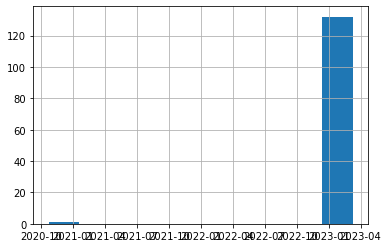

In [19]:
df_final_samsung[df_final_samsung.device=='Galaxy S20 FE 5G']['last_release_date'].hist()

In [20]:
df_final_samsung[(df_final_samsung.device=='Galaxy S20 FE 5G')&(df_final_samsung['last_release_date']<'2021-01-01')]

,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
11882,SM-G781B/XEH,Galaxy S20 FE 5G,SM-G781B,XEH,smartphone,True,Knox,Hungary,No-carrier,Hungary,...,30 days,23 days,3,3,10.0,7.666667,2020-09-29,2020-10-22,22.0,https://doc.samsungmobile.com/SM-G781B/XEH/doc...


In [21]:
df_final_samsung[(df_final_samsung.device=='Galaxy A8+ (2018)')&(df_final_samsung['last_release_date']>'2022-02-01')]

,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
103,SM-A730F/ALE,Galaxy A8+ (2018),SM-A730F,ALE,smartphone,False,Knox,Ecuador,No-carrier,Ecuador,...,1249 days,1267 days,13,13,96.076923,97.461538,2018-08-17,2022-02-04,62.0,https://doc.samsungmobile.com/SM-A730F/ALE/doc...
107,SM-A730F/BVO,Galaxy A8+ (2018),SM-A730F,BVO,smartphone,False,Knox,Bolivia,No-carrier,Bolivia,...,1249 days,1485 days,17,17,73.470588,87.352941,2018-01-15,2022-02-08,43.0,https://doc.samsungmobile.com/SM-A730F/BVO/doc...
110,SM-A730F/CDR,Galaxy A8+ (2018),SM-A730F,CDR,smartphone,False,Knox,Dominican Republic,No-carrier,Dominican Republic,...,1218 days,1427 days,20,20,60.900000,71.350000,2018-03-17,2022-02-11,57.0,https://doc.samsungmobile.com/SM-A730F/CDR/doc...
112,SM-A730F/CGU,Galaxy A8+ (2018),SM-A730F,CGU,smartphone,False,Knox,Guatemala (Tigo),Tigo,Guatemala,...,1249 days,1177 days,12,12,104.083333,98.083333,2018-11-22,2022-02-11,68.0,https://doc.samsungmobile.com/SM-A730F/CGU/doc...
113,SM-A730F/CHO,Galaxy A8+ (2018),SM-A730F,CHO,smartphone,False,Knox,Chile,No-carrier,Chile,...,1249 days,1490 days,17,17,73.470588,87.647059,2018-01-13,2022-02-11,39.0,https://doc.samsungmobile.com/SM-A730F/CHO/doc...
115,SM-A730F/COO,Galaxy A8+ (2018),SM-A730F,COO,smartphone,False,Knox,Colombia,No-carrier,Colombia,...,1249 days,1395 days,16,16,78.062500,87.187500,2018-04-11,2022-02-04,38.0,https://doc.samsungmobile.com/SM-A730F/COO/doc...
116,SM-A730F/CTE,Galaxy A8+ (2018),SM-A730F,CTE,smartphone,False,Knox,Honduras,No-carrier,Honduras,...,1249 days,1176 days,12,12,104.083333,98.000000,2018-11-23,2022-02-11,69.0,https://doc.samsungmobile.com/SM-A730F/CTE/doc...
117,SM-A730F/DOO,Galaxy A8+ (2018),SM-A730F,DOO,smartphone,False,Knox,Dominican Republic,No-carrier,Dominican Republic,...,1249 days,1472 days,17,17,73.470588,86.588235,2018-01-24,2022-02-04,49.0,https://doc.samsungmobile.com/SM-A730F/DOO/doc...
119,SM-A730F/ECO,Galaxy A8+ (2018),SM-A730F,ECO,smartphone,False,Knox,Ecuador,No-carrier,Ecuador,...,1249 days,1402 days,19,19,65.736842,73.789474,2018-04-10,2022-02-10,47.0,https://doc.samsungmobile.com/SM-A730F/ECO/doc...
122,SM-A730F/EON,Galaxy A8+ (2018),SM-A730F,EON,smartphone,False,Knox,Trinidad and Tobago,No-carrier,Trinidad and Tobago,...,1249 days,1483 days,18,18,69.388889,82.388889,2018-01-13,2022-02-04,40.0,https://doc.samsungmobile.com/SM-A730F/EON/doc...


## Discrepancy between the support list and security updates:

<AxesSubplot:>

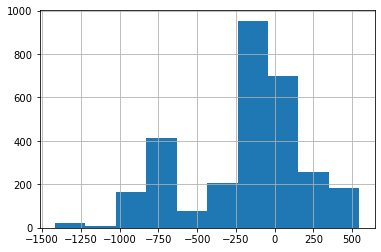

In [22]:
df_final_biannual_ended['eol_diff'] = pd.to_datetime(df_final_biannual_ended['last_release_date'])-pd.to_datetime(df_final_biannual_ended['biannual_end'])

df_final_biannual_ended['eol_diff'].dt.days.hist()

In [23]:
df_final_biannual_ended[df_final_biannual_ended['eol_diff'].dt.days>365]

,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url,biannual_end,eol_diff
13350,SM-J510F/KSA,Galaxy J5 (2016),SM-J510F,KSA,smartphone,False,Knox,Saudi Arabia,No-carrier,Saudi Arabia,...,2,2,0.000000,206.000000,2019-11-08,2020-12-24,244.0,https://doc.samsungmobile.com/SM-J510F/KSA/doc...,2019-11-26 01:44:41,393 days 22:15:19
13352,SM-J510F/MAT,Galaxy J5 (2016),SM-J510F,MAT,smartphone,False,Knox,Morocco (MAT),MAT,Morocco,...,1,1,0.000000,0.000000,2021-01-08,2021-01-08,952.0,https://doc.samsungmobile.com/SM-J510F/MAT/doc...,2019-11-26 01:44:41,408 days 22:15:19
13353,SM-J510F/MID,Galaxy J5 (2016),SM-J510F,MID,smartphone,False,Knox,Iraq,No-carrier,Iraq,...,1,1,0.000000,0.000000,2020-12-31,2020-12-31,944.0,https://doc.samsungmobile.com/SM-J510F/MID/doc...,2019-11-26 01:44:41,400 days 22:15:19
13354,SM-J510F/MWD,Galaxy J5 (2016),SM-J510F,MWD,smartphone,False,Knox,Morocco (MWD),MWD,Morocco,...,2,2,0.000000,206.000000,2019-11-08,2020-12-24,244.0,https://doc.samsungmobile.com/SM-J510F/MWD/doc...,2019-11-26 01:44:41,393 days 22:15:19
13355,SM-J510F/PAK,Galaxy J5 (2016),SM-J510F,PAK,smartphone,False,Knox,Pakistan (PAK),PAK,Pakistan,...,2,2,0.000000,213.500000,2019-11-08,2021-01-08,251.0,https://doc.samsungmobile.com/SM-J510F/PAK/doc...,2019-11-26 01:44:41,408 days 22:15:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15990,SM-J410F/XFE,Galaxy J4 Core,SM-J410F,XFE,smartphone,False,AndroidGo,South Africa,No-carrier,South Africa,...,11,11,63.636364,129.272727,2019-02-06,2022-12-29,116.0,https://doc.samsungmobile.com/SM-J410F/XFE/doc...,2021-11-01 20:22:48,422 days 03:37:12
15991,SM-J410F/XFV,Galaxy J4 Core,SM-J410F,XFV,smartphone,False,AndroidGo,South Africa (Vodafone),Vodafone,South Africa,...,11,11,63.636364,131.545455,2019-02-01,2023-01-18,122.0,https://doc.samsungmobile.com/SM-J410F/XFV/doc...,2021-11-01 20:22:48,442 days 03:37:12
15992,SM-J410F/XME,Galaxy J4 Core,SM-J410F,XME,smartphone,False,AndroidGo,Malaysia,No-carrier,Malaysia,...,9,9,61.000000,139.444444,2019-07-03,2022-12-09,118.0,https://doc.samsungmobile.com/SM-J410F/XME/doc...,2021-11-01 20:22:48,402 days 03:37:12
15993,SM-J410F/XSG,Galaxy J4 Core,SM-J410F,XSG,smartphone,False,AndroidGo,United Arab Emirates,No-carrier,United Arab Emirates,...,11,11,63.636364,129.909091,2019-01-30,2022-12-29,105.0,https://doc.samsungmobile.com/SM-J410F/XSG/doc...,2021-11-01 20:22:48,422 days 03:37:12


# Oppo

In [24]:
import pandas as pd
import requests
from urllib.parse import quote
import os 
import pycountry

# Read in your original DataFrame
df_oppo = pd.read_csv('../Data/Oppo/Oppo-security-updates.csv')

#convert the date column to datetime format
df_oppo['date']= pd.to_datetime(df_oppo['date'])

df_regions = pd.read_csv('../Data/Oppo/available-links-regions.csv')

#counter=0
for i in df_oppo.index:
    
    region_url = df_oppo.loc[i,'region_url']
    
    country = df_regions.loc[df_regions['Available Links'] == region_url,'Country'].tolist()
    df_oppo.at[i,'country'] = country[0]
    
    region = df_regions.loc[df_regions['Available Links'] == region_url,'Region'].tolist()
    df_oppo.at[i,'region'] = region[0]
    
    lang = df_regions.loc[df_regions['Available Links'] == region_url,'lang'].tolist()
    df_oppo.at[i,'lang'] = lang[0]
    
df_oppo['filename'] = df_oppo['Download Link'].apply(lambda x: os.path.basename(x))  
    
df_spl = pd.read_csv("../Data/Oppo/firmware_SPLs.csv")

#drop the duplicates
df_spl = df_spl.drop_duplicates(subset='filename', keep='first')

# Rename the column
df_spl = df_spl.rename(columns={'google_patch': 'SPL'})

# Merge the dataframes
df_oppo = pd.merge(df_oppo, df_spl, on='filename', how='left')

# Replace NaN with 'NotFound'
df_oppo['SPL'] = df_oppo['SPL'].fillna('NotFound')

#Calculate delay     
df_oppo['SPL'].replace('NotFound', pd.NaT, inplace=True)
df_oppo['SPL'] = pd.to_datetime(df_oppo['SPL'], format='%Y%m%d', errors='ignore')
df_oppo['delay'] = (df_oppo['date'] - df_oppo['SPL']).dt.days

#add ISO codes
df_oppo['ISO'] = df_oppo['country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) is not None else None)


df_oppo['Device Model'] = df_oppo['Device Model'].replace(dict.fromkeys(['EX','PUEX','PU','EU','TW'], ''), regex=True)

df_oppo

,Product Name,Version No,Size,Update Date,Download Times,Download Link,url,date,Device Model,ColorOS Version,...,region,lang,filename,file_path,first_12_bytes,file_extension,SPL,identifier,delay,ISO
0,OPPO Reno2 F,CPH1989EX_11_C.20,2.91 GB,2021/05/10,"1,611",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2021-05-10,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1200_all_f5jdg3ZRx4WG.ozip,/Volumes/Expansion/Oppo/652_https___assorted.d...,OPPOENCRYPT!,ozip,2021-04-05,652.0,35.0,DZA
1,OPPO Reno2 F,CPH1989EX_11_C.19,2.87 GB,2021/03/11,"1,246",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2021-03-11,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1190_all_BNmwe83KIV98.ozip,/Volumes/Expansion/Oppo/651_https___assorted.d...,OPPOENCRYPT!,ozip,2021-02-05,651.0,34.0,DZA
2,OPPO Reno2 F,CPH1989EX_11_C.17,2.83 GB,2020/12/18,"7,092",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-12-18,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1170_all_UYw3OL95EtlM.ozip,/Volumes/Expansion/Oppo/650_https___assorted.d...,OPPOENCRYPT!,ozip,2020-12-05,650.0,13.0,DZA
3,OPPO Reno2 F,CPH1989EX_11_C.15,2.82 GB,2020/10/15,"5,344",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-10-15,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1150_all_HcOBVqySu4QL.ozip,/Volumes/Expansion/Oppo/649_https___assorted.d...,OPPOENCRYPT!,ozip,2020-09-05,649.0,40.0,DZA
4,OPPO Reno2 F,CPH1989_11_A.18,2.6 GB,2020/08/18,"3,986",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-08-18,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_0180_all_hzB4QMDBLuVP.ozip,/Volumes/Expansion/Oppo/648_https___assorted.d...,OPPOENCRYPT!,ozip,2020-06-05,648.0,74.0,DZA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9236,OPPO R15 Pro,CPH1831EX_11_A.18_190527,2.4 GB,2019/06/24,"1,262",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/tw/software-update/so...,2019-06-24,CPH1831,11,...,Asia Pacific,zh,CPH1831EX_11_OTA_0180_all_CifKBktqrKQx.ozip,/Volumes/Expansion/Oppo/254_https___assorted.d...,OPPOENCRYPT!,ozip,NaT,254.0,NaN,None
9237,OPPO R15 Pro,CPH1831EX_11_A.17_190326,2.51 GB,2019/05/22,"1,461",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/tw/software-update/so...,2019-05-22,CPH1831,11,...,Asia Pacific,zh,CPH1831EX_11_OTA_0170_all_Q2GOz9afhZPM.ozip,/Volumes/Expansion/Oppo/188_https___assorted.d...,OPPOENCRYPT!,ozip,NaT,188.0,NaN,None
9238,OPPO R15 Pro,CPH1831EX_11_A.15_181221_8368f1e9,2.25 GB,2019/01/10,"1,885",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/tw/software-update/so...,2019-01-10,CPH1831,11,...,Asia Pacific,zh,CPH1831EX_11_A.15_OTA_0150_all_201812211048.ozip,/Volumes/Expansion/Oppo/113_https___assorted.d...,OPPOENCRYPT!,ozip,NaT,113.0,NaN,None
9239,OPPO R15 Pro,CPH1831EX_11_A.13_181121,2.1 GB,2018/12/27,"2,291",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/tw/software-update/so...,2018-12-27,CPH1831,11,...,Asia Pacific,zh,CPH1831EX_11_A.13_OTA_0130_all_201811212153.ozip,/Volumes/Expansion/Oppo/253_https___assorted.d...,OPPOENCRYPT!,ozip,NaT,253.0,NaN,None


In [25]:
import pandas as pd
from datetime import datetime
import pycountry

d = []
counter = 0

for url in df_oppo['url'].unique():
    
    df_test = df_oppo[df_oppo['url']==url]
    
    device = df_test['Product Name'].to_list()
    country = df_test['country'].to_list()
    region = df_test['region'].to_list()
    
    update_count = len(df_test)
    
    first_update_date = df_test['date'].min()
    last_update_date = df_test['date'].max()
    support_duration = (last_update_date-first_update_date).days
    update_frequency = support_duration / update_count
    
    avg_delay = df_test['delay'].median()
    
    coloros_version = df_test.loc[df_test['date']==last_update_date,'ColorOS Version'].to_list()
    
    
    d.append({'url': url,
          'device': device[0],
          'country': country[0],
          'region': region[0],
          'last_android_version': coloros_version[0],
          'update_count': update_count,
          'first_update_date': first_update_date,
          'last_update_date': last_update_date,
          'support_duration': support_duration,
          'update_frequency': update_frequency,
          'delay': avg_delay})
    
    counter = counter + 1
    
    print('Completed {} / {}'.format(counter,len(df_oppo['url'].unique())), end='\r')
    
df_final_oppo = pd.DataFrame(d)

# Assuming your DataFrame is named df_final and the column with the country names is 'country'
df_final_oppo['ISO'] = df_final_oppo['country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) is not None else None)


df_final_oppo

,url,device,country,region,last_android_version,update_count,first_update_date,last_update_date,support_duration,update_frequency,delay,ISO
0,https://support.oppo.com/dz/software-update/so...,OPPO Reno2 F,Algeria,Africa & Middle East,11,8,2019-10-14,2021-05-10,574,71.750000,37.0,DZA
1,https://support.oppo.com/dz/software-update/so...,OPPO Reno3,Algeria,Africa & Middle East,11,3,2020-09-25,2021-01-05,102,34.000000,NaN,DZA
2,https://support.oppo.com/dz/software-update/so...,OPPO A9 2020,Algeria,Africa & Middle East,11,8,2019-12-05,2021-07-26,599,74.875000,NaN,DZA
3,https://support.oppo.com/dz/software-update/so...,OPPO A11k,Algeria,Africa & Middle East,11,5,2021-04-12,2022-03-30,352,70.400000,NaN,DZA
4,https://support.oppo.com/dz/software-update/so...,OPPO A12,Algeria,Africa & Middle East,11,6,2021-01-05,2022-03-30,449,74.833333,NaN,DZA
...,...,...,...,...,...,...,...,...,...,...,...,...
1119,https://support.oppo.com/tw/software-update/so...,OPPO F1s,Taiwan,Asia Pacific,11,6,2018-03-10,2021-11-15,1346,224.333333,NaN,None
1120,https://support.oppo.com/tw/software-update/so...,OPPO F1,Taiwan,Asia Pacific,11,2,2018-03-10,2019-08-27,535,267.500000,NaN,None
1121,https://support.oppo.com/tw/software-update/so...,OPPO R17 Pro,Taiwan,Asia Pacific,11,25,2018-12-06,2021-07-09,946,37.840000,38.0,None
1122,https://support.oppo.com/tw/software-update/so...,OPPO RX17 Neo,Taiwan,Asia Pacific,11,3,2019-07-31,2019-12-07,129,43.000000,NaN,None


In [26]:
cond1 = df_final_oppo['device'].str.contains('Reno4')

cond2 = df_final_oppo['last_update_date']<'2021-01-01'

df_final_oppo_reno = df_final_oppo[cond1&cond2]

df_final_oppo_reno['device'].value_counts()

OPPO Reno4         14
OPPO Reno4 5G       1
OPPO Reno4 Lite     1
OPPO Reno4 F        1
Name: device, dtype: int64

In [27]:
df_final_oppo_reno

,url,device,country,region,last_android_version,update_count,first_update_date,last_update_date,support_duration,update_frequency,delay,ISO
40,https://support.oppo.com/eg/software-update/so...,OPPO Reno4,Egypt,Africa & Middle East,11,2,2020-09-05,2020-12-19,105,52.5,14.0,EGY
76,https://support.oppo.com/ke/software-update/so...,OPPO Reno4,Kenya,Africa & Middle East,11,2,2020-09-05,2020-12-19,105,52.5,14.0,KEN
102,https://support.oppo.com/ma/software-update/so...,OPPO Reno4,Morocco,Africa & Middle East,11,2,2020-09-05,2020-12-19,105,52.5,14.0,MAR
125,https://support.oppo.com/ng/software-update/so...,OPPO Reno4,Nigeria,Africa & Middle East,11,2,2020-09-05,2020-12-19,105,52.5,14.0,NGA
171,https://support.oppo.com/tn/software-update/so...,OPPO Reno4,Tunisia,Africa & Middle East,11,2,2020-09-05,2020-12-19,105,52.5,14.0,TUN
194,https://support.oppo.com/ae/software-update/so...,OPPO Reno4,UAE,Africa & Middle East,11,2,2020-09-05,2020-12-19,105,52.5,14.0,None
220,https://support.oppo.com/au/software-update/so...,OPPO Reno4 5G,Australia,Asia Pacific,11,2,2020-11-10,2020-12-14,34,17.0,NaN,AUS
237,https://support.oppo.com/bd/software-update/so...,OPPO Reno4,Bangladesh,Asia Pacific,11,2,2020-09-05,2020-12-19,105,52.5,14.0,BGD
268,https://support.oppo.com/kh/software-update/so...,OPPO Reno4,Cambodia,Asia Pacific,11,2,2020-09-05,2020-12-19,105,52.5,14.0,KHM
327,https://support.oppo.com/id/software-update/so...,OPPO Reno4,Indonesia,Asia Pacific,11,2,2020-09-13,2020-12-19,97,48.5,14.0,IDN


## Inconsistency between the AER guarantted date and security updates

In [28]:
df_final_aer = df_final_samsung[(df_final_samsung.aer==True)]

In [29]:
df_final_aer[df_final_aer['last_release_date']<'2020-01-01']
df_final_aer[df_final_aer['last_release_date']<'2020-01-01']['url'].to_list()

['https://doc.samsungmobile.com/SM-N975F/BHT/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/CYV/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/ORO/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/ZTR/doc.html',
 'https://doc.samsungmobile.com/SM-N976B/VD2/doc.html',
 'https://doc.samsungmobile.com/SM-N970F/CYV/doc.html',
 'https://doc.samsungmobile.com/SM-N970F/ORO/doc.html',
 'https://doc.samsungmobile.com/SM-N970F/PGU/doc.html',
 'https://doc.samsungmobile.com/SM-N970F/ZTR/doc.html',
 'https://doc.samsungmobile.com/SM-G970F/CRM/doc.html',
 'https://doc.samsungmobile.com/SM-G970F/ICE/doc.html',
 'https://doc.samsungmobile.com/SM-G970F/PCW/doc.html',
 'https://doc.samsungmobile.com/SM-G973F/CRM/doc.html',
 'https://doc.samsungmobile.com/SM-N970F/BHT/doc.html',
 'https://doc.samsungmobile.com/SM-G975F/CRM/doc.html']

In [30]:
df_final_aer[df_final_aer['last_release_date']<'2022-01-01']
df_final_aer[df_final_aer['last_release_date']<'2022-01-01']['url'].to_list()

['https://doc.samsungmobile.com/SM-N975F/BHT/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/BVO/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/CDR/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/CYV/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/NPL/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/ORO/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/PCW/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/ZTO/doc.html',
 'https://doc.samsungmobile.com/SM-N975F/ZTR/doc.html',
 'https://doc.samsungmobile.com/SM-N975U1/SPR/doc.html',
 'https://doc.samsungmobile.com/SM-N975U1/TFN/doc.html',
 'https://doc.samsungmobile.com/SM-N975U1/TMB/doc.html',
 'https://doc.samsungmobile.com/SM-N975U1/TMK/doc.html',
 'https://doc.samsungmobile.com/SM-N975U1/XAG/doc.html',
 'https://doc.samsungmobile.com/SM-N975U1/XAR/doc.html',
 'https://doc.samsungmobile.com/SM-N976B/VD2/doc.html',
 'https://doc.samsungmobile.com/SM-N970F/BVO/doc.html',
 'https://doc.samsungmobile.com/SM-N970F/C